# Derive Gauge Configuration — ausvic (FloodHubMaribyrnong)

This notebook reproduces every value in the `GAUGES` list from primary sources.
Run it end-to-end to verify or update the gauge configuration.

| Field | Source |
|-------|--------|
| `gauge_id` | Caravan convention: `ausvic_` + station number (no letters) |
| `name` | Victorian Water: Hydstra `get_ts_traces` → `site_details.name`; Melbourne Water: `/locations` API |
| `lat` / `lon` | Victorian Water: Hydstra `get_ts_traces` → `site_details`; Melbourne Water: `/locations` + `/summary` API |
| `area_km2` | MERIT Hydro (`MERIT/Hydro/v1_0_1`, `upa` band) at 90 m via GEE for most gauges; Keilor (230200): official VW figure 1305.4 km²; Mt Macedon (230213) and Kerrie (230227): HydroBASINS L12 UP_AREA (MERIT off-network at these headwater sites) |
| Exclusions | CAMELS AUS v2 overlap check (Zenodo 13350616) — CSV required |

**Steps**
1. Candidate discovery + CAMELS AUS v2 overlap
2. Victorian Water metadata — name/lat/lon from Hydstra `get_ts_traces` site_details
3. Melbourne Water metadata — name/lat/lon from `/locations` + `/summary` API
4. Catchment areas — MERIT Hydro `upa` band via GEE (90 m), with `KNOWN_AREAS` overrides
5. Compile final `GAUGES` list

In [133]:
import json
import time
import urllib.parse
import urllib.request
from datetime import datetime
from pathlib import Path
from zoneinfo import ZoneInfo

_mel = ZoneInfo('Australia/Melbourne')
print(f'Notebook last run: {datetime.now(_mel).strftime("%Y-%m-%d %H:%M %Z")}')
print('Ready.')

Notebook last run: 2026-02-27 14:37 AEDT
Ready.


In [134]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Step 1 — Candidate Station Discovery and CAMELS AUS v2 Overlap Check

**1a — Victorian Water candidates**  
Known 230* stations confirmed to carry discharge (141.00 = ML/day).  
Names and coordinates are fetched from the Hydstra API in Step 2.

**1b — Melbourne Water candidates via `/locations` API**  
Call `api.melbournewater.com.au/rainfall-river-level/locations` to get all MW sites.  
Filter to those with a `230` prefix (Maribyrnong basin). Use `/summary` to confirm  
each site has flow data (`flowLevels.minYear` present) and extract any available  
lat/lon from both responses.

**1c — CAMELS AUS v2 overlap**  
Any candidate already in Caravan via CAMELS AUS v2 (Zenodo 13350616) is excluded  
to avoid duplicate gauge IDs across the global dataset.

> **CAMELS CSV required.**  
> Download `CAMELS_AUS_Attributes&Indices_MasterTable.csv` from  
> [Zenodo record 13350616](https://doi.org/10.5281/zenodo.13350616) and place it in  
> `MyDrive/Colab Notebooks/`. The cell raises a `FileNotFoundError` if it is missing.

In [135]:
# ── Step 1a / Step 2 combined: Victorian Water metadata (Hydstra API) ─────────
# Station IDs are the known 230* gauges confirmed to carry discharge (141.00 ML/day).
# get_site_list is not exposed on this public endpoint — name/lat/lon come from
# the site_details object embedded in every get_ts_traces response.

import json as _json, urllib.parse as _up, urllib.request as _ur, time as _time

HYDSTRA_BASE = 'https://data.water.vic.gov.au/cgi/webservice.exe'
VW_STATIONS  = ['230200', '230206', '230202', '230213', '230227']

vw_meta = {}

print(f'  {"Station":<10} {"Name":<42} {"Lat":>12} {"Lon":>13}')
print('  ' + '-' * 82)

for sid in VW_STATIONS:
    params = {
        'function':   'get_ts_traces',
        'version':    '2',
        'site_list':  sid,
        'datasource': 'PUBLISH',
        'varfrom':    '100.00',
        'varto':      '141.00',
        'start_time': '20240601000000',
        'end_time':   '20240601235959',
        'interval':   'day',
        'multiplier': '1',
        'data_type':  'mean',
    }
    url = HYDSTRA_BASE + '?' + _up.urlencode(params)
    with _ur.urlopen(url, timeout=30) as resp:
        data = _json.loads(resp.read().decode())

    traces = data.get('return', {}).get('traces', [])
    if not traces:
        raise RuntimeError(f'No trace returned for Hydstra station {sid}')

    sd   = traces[0].get('site_details', {})
    name = sd.get('name', '').strip()
    lat  = float(sd.get('latitude', 0))
    lon  = float(sd.get('longitude', 0))

    if not name or lat == 0 or lon == 0:
        raise ValueError(f'Incomplete site_details for {sid}: {sd}')

    vw_meta[sid] = {'name': name, 'lat': lat, 'lon': lon}
    print(f'  {sid:<10} {name:<42} {lat:>12.6f} {lon:>13.6f}')
    _time.sleep(0.3)

print(f'\n{len(vw_meta)} Victorian Water gauges fetched from Hydstra API')

  Station    Name                                                Lat           Lon
  ----------------------------------------------------------------------------------
  230200     MARIBYRNONG RIVER @ KEILOR                   -37.727706    144.836476
  230206     JACKSON CREEK @ GISBORNE                     -37.475370    144.572443
  230202     JACKSON CREEK @ SUNBURY                      -37.583217    144.742036
  230213     TURRITABLE CREEK @ MOUNT MACEDON             -37.418905    144.584810
  230227     MAIN CREEK @ KERRIE                          -37.396121    144.660395

5 Victorian Water gauges fetched from Hydstra API


In [136]:
# ── Step 1b: Discover Melbourne Water candidates via /locations API ────────────
MELBWATER_BASE = 'https://api.melbournewater.com.au/rainfall-river-level'

MW_HEADERS = {
    'User-Agent': 'Mozilla/5.0',
    'Accept':     'application/json',
    'Origin':     'https://www.melbournewater.com.au',
    'Referer':    'https://www.melbournewater.com.au/',
}

# Known agency duplicates — same physical gauge as a Hydstra station, shorter record.
MW_AGENCY_DUPLICATES = {
    '230104A': 'agency duplicate of Hydstra 230202',
    '230105A': 'agency duplicate of Hydstra 230200',
}

# Gauges with flow data that are explicitly excluded for other reasons.
# These pass the automated filters but are unsuitable for Caravan.
MW_KNOWN_EXCLUSIONS = {
    '230236A': ('minimal flow only — 2.3 ML/day during Oct 2022 major flood peak; '
                'catchment area unknown; insufficient for hydrological characterisation'),
}

def check_flow_direct(sid):
    """
    Fall back to a direct flow request when /summary doesn't expose flowLevels.
    Uses the Oct 2022 Maribyrnong flood window (10–20 Oct 2022).
    MW API returns flow data under the key 'dailyRiverFlowsData'.
    Returns (has_flow: bool, min_year_label: str | None).
    """
    test_url = (f'{MELBWATER_BASE}/{sid}/river-flow/daily/range'
                f'?fromDate=2022-10-10&toDate=2022-10-20')
    req = urllib.request.Request(test_url, headers=MW_HEADERS)
    try:
        with urllib.request.urlopen(req, timeout=15) as resp:
            records = json.loads(resp.read().decode())
        items = records.get('dailyRiverFlowsData', [])
        if items:
            return True, '(Oct 2022 flood)'
    except Exception as e:
        print(f'    [debug {sid}] error: {e}')
    return False, None

# 1. Get the full locations list
req = urllib.request.Request(f'{MELBWATER_BASE}/locations', headers=MW_HEADERS)
with urllib.request.urlopen(req, timeout=30) as resp:
    all_locations = json.loads(resp.read().decode()).get("siteLocations", [])

print(f'Melbourne Water /locations returned {len(all_locations)} total sites')

maribyrnong_sites = [
    loc for loc in all_locations
    if str(loc.get('siteId', '')).startswith('230')
]
print(f'  {len(maribyrnong_sites)} sites with prefix 230')
print(f'\nSample location object fields: {sorted(maribyrnong_sites[0].keys()) if maribyrnong_sites else "none"}')
print()

# 2. Process each site — filter out non-streamflow gauges, check for flow data
mw_candidates = {}

print(f'  {"Site ID":<12} {"Name":<40} {"Status":<30} {"Min year":>10} {"Lat":>10} {"Lon":>11}')
print('  ' + '-' * 118)

for loc in maribyrnong_sites:
    sid  = str(loc.get('siteId', '')).strip()
    name = (loc.get('siteName') or loc.get('name') or loc.get('description') or sid).strip()

    # Filter 1: reservoirs — not a streamflow gauge
    if loc.get('reservoirRecording'):
        print(f'  {sid:<12} {name:<40} SKIP — reservoir')
        continue

    # Filter 2: agency duplicates — same physical gauge as a Hydstra station
    if sid in MW_AGENCY_DUPLICATES:
        print(f'  {sid:<12} {name:<40} SKIP — {MW_AGENCY_DUPLICATES[sid]}')
        continue

    # Filter 3: explicitly excluded gauges (flow present but unsuitable for Caravan)
    if sid in MW_KNOWN_EXCLUSIONS:
        print(f'  {sid:<12} {name:<40} SKIP — {MW_KNOWN_EXCLUSIONS[sid]}')
        continue

    # Call /summary for flow info and coordinates
    summary_url = f'{MELBWATER_BASE}/{sid}/summary'
    req = urllib.request.Request(summary_url, headers=MW_HEADERS)
    try:
        with urllib.request.urlopen(req, timeout=15) as resp:
            summary = json.loads(resp.read().decode())
        flow     = summary.get('flowLevels', {})
        min_yr   = flow.get('minYear')
        has_flow = min_yr is not None
        lat = (summary.get('latitude') or summary.get('lat') or
               loc.get('latitude') or loc.get('lat'))
        lon = (summary.get('longitude') or summary.get('lon') or
               loc.get('longitude') or loc.get('lng') or loc.get('lon'))
    except Exception:
        has_flow = False
        min_yr   = None
        lat = lon = None

    # Filter 4: very short records (started 2025 or later — insufficient for Caravan)
    if min_yr is not None and int(min_yr) >= 2025:
        print(f'  {sid:<12} {name:<40} SKIP — record from {min_yr} only')
        continue

    # Stage b: direct flood-date check for gauges /summary misses
    # MW API flow data is under key 'dailyRiverFlowsData' (confirmed from debug output)
    if not has_flow:
        has_flow, min_yr = check_flow_direct(sid)

    mw_candidates[sid] = {
        'name': name, 'has_flow': has_flow, 'min_year': min_yr,
        'lat': float(lat) if lat is not None else None,
        'lon': float(lon) if lon is not None else None,
    }
    status = 'YES' if has_flow else 'no flow'
    lat_s  = f'{float(lat):.4f}' if lat is not None else 'N/A'
    lon_s  = f'{float(lon):.4f}' if lon is not None else 'N/A'
    print(f'  {sid:<12} {name:<40} {status:<30} {str(min_yr or ""):>10} {lat_s:>10} {lon_s:>11}')
    time.sleep(0.3)

mw_with_flow = {sid: v for sid, v in mw_candidates.items() if v['has_flow']}
print(f'\n{len(mw_with_flow)} Melbourne Water sites with flow records')

Melbourne Water /locations returned 236 total sites
  16 sites with prefix 230

Sample location object fields: ['currentRainfallLevel', 'currentRiverLevel', 'latitude', 'longitude', 'recordsRainfall', 'recordsRiverLevel', 'reservoirRecording', 'siteId', 'siteName', 'siteWarningMessage', 'siteWarningReported']

  Site ID      Name                                     Status                           Min year        Lat         Lon
  ----------------------------------------------------------------------------------------------------------------------
  230100A      Darraweit                                YES                                  1996   -37.4103    144.9023
  230102A      Bulla North                              YES                            (Oct 2022 flood)   -37.6314    144.8010
  230103A      Rosslynne Reservoir                      SKIP — reservoir
  230104A      Sunbury                                  SKIP — agency duplicate of Hydstra 230202
  230105A      Keilor      

In [137]:
# ── Step 1c: Combine all candidates then CAMELS AUS v2 overlap check ──────────
import pandas as pd

ALL_CANDIDATES = {
    **{sid: v['name'] for sid, v in vw_meta.items()},
    **{sid: v['name'] for sid, v in mw_with_flow.items()},
}
print(f'Total candidates (VW + MW, with discharge): {len(ALL_CANDIDATES)}')
for sid, name in sorted(ALL_CANDIDATES.items()):
    print(f'  {sid:<12} {name}')

# CAMELS AUS v2 overlap check — CSV required (download from Zenodo record 13350616)
CAMELS_CSV = Path('/content/drive/MyDrive/Colab Notebooks/CAMELS_AUS_Attributes&Indices_MasterTable.csv')

if not CAMELS_CSV.exists():
    raise FileNotFoundError(
        f'CAMELS CSV not found at {CAMELS_CSV}\n'
        'Download from https://doi.org/10.5281/zenodo.13350616 and place in '
        'MyDrive/Colab Notebooks/'
    )

camels     = pd.read_csv(CAMELS_CSV, dtype=str)
camels_ids = set(camels['station_id'].str.strip())
print(f'\nCAMELS AUS v2 loaded — {len(camels_ids)} stations\n')

EXCLUDED = set()
print(f'  {"Station":<12} {"Name":<45} Status')
print('  ' + '-' * 70)
for sid, name in sorted(ALL_CANDIDATES.items()):
    camels_sid = sid.rstrip('ABCDEFGHIJKLMNOPQRSTUVWXYZ')
    if camels_sid in camels_ids:
        EXCLUDED.add(sid)
        status = 'DUPLICATE -> EXCLUDED'
    else:
        status = 'OK'
    print(f'  {sid:<12} {name:<45} {status}')

INCLUDED = {sid: name for sid, name in ALL_CANDIDATES.items() if sid not in EXCLUDED}
print(f'\nResult: {len(INCLUDED)} included, {len(EXCLUDED)} excluded: {sorted(EXCLUDED)}')

Total candidates (VW + MW, with discharge): 12
  230100A      Darraweit
  230102A      Bulla North
  230106A      Maribyrnong
  230107A      Konagaderra
  230119A      Lancefield
  230200       MARIBYRNONG RIVER @ KEILOR
  230202       JACKSON CREEK @ SUNBURY
  230206       JACKSON CREEK @ GISBORNE
  230211A      Clarkefield
  230213       TURRITABLE CREEK @ MOUNT MACEDON
  230227       MAIN CREEK @ KERRIE
  230237A      Keilor North

CAMELS AUS v2 loaded — 561 stations

  Station      Name                                          Status
  ----------------------------------------------------------------------
  230100A      Darraweit                                     OK
  230102A      Bulla North                                   OK
  230106A      Maribyrnong                                   OK
  230107A      Konagaderra                                   OK
  230119A      Lancefield                                    OK
  230200       MARIBYRNONG RIVER @ KEILOR                    OK

## Step 3 — Melbourne Water Gauge Metadata

Coordinates and names are extracted from the `/locations` and `/summary` API  
responses fetched in Step 1b. The "Sample location object fields" output in Step 1b  
shows every field the API exposes — if coordinates are not found, Step 3 will raise  
a `ValueError` identifying the affected gauges.

In [138]:
# ── Step 3: Melbourne Water metadata from /locations + /summary ───────────────
# Coordinates are extracted in Step 1b from the /summary and /locations API
# responses. No hardcoded fallback — if the API doesn't return coords for a
# gauge in our included set the cell will raise an error.

loc_lookup = {str(loc.get('siteId', '')).strip(): loc for loc in all_locations}

print(f'  {"Site ID":<12} {"Name":<40} {"Min year":>10} {"Lat":>12} {"Lon":>13} {"Coord source"}')
print('  ' + '-' * 102)

mw_meta = {}
missing_coords = []

for sid, v in sorted(mw_with_flow.items()):
    if sid in EXCLUDED:
        continue

    name = v['name']
    lat  = v.get('lat')
    lon  = v.get('lon')
    coord_src = 'API' if lat is not None else 'MISSING'

    if lat is None or lon is None:
        missing_coords.append(sid)

    mw_meta[sid] = {'name': name, 'lat': lat, 'lon': lon, 'min_year': v['min_year']}
    lat_s = f'{lat:.6f}' if lat is not None else 'MISSING'
    lon_s = f'{lon:.6f}' if lon is not None else 'MISSING'
    print(f'  {sid:<12} {name:<40} {str(v["min_year"]):>10} {lat_s:>12} {lon_s:>13}  {coord_src}')

print(f'\n{len(mw_meta)} Melbourne Water gauges ready')

if missing_coords:
    raise ValueError(
        f'Coordinates missing for {missing_coords}.\n'
        'The Melbourne Water API did not return lat/lon for these gauges.\n'
        'Check the "Sample location object fields" output in Step 1b to find\n'
        'the correct field names, then update the lat/lon extraction in that cell.'
    )

  Site ID      Name                                       Min year          Lat           Lon Coord source
  ------------------------------------------------------------------------------------------------------
  230100A      Darraweit                                      1996   -37.410313    144.902285  API
  230102A      Bulla North                              (Oct 2022 flood)   -37.631400    144.801000  API
  230106A      Maribyrnong                                    1996   -37.765900    144.895000  API
  230107A      Konagaderra                                    1996   -37.528500    144.856000  API
  230119A      Lancefield                               (Oct 2022 flood)   -37.286090    144.777750  API
  230211A      Clarkefield                                    2008   -37.466200    144.744000  API
  230237A      Keilor North                             (Oct 2022 flood)   -37.677800    144.805000  API

7 Melbourne Water gauges ready


## Step 4 — Catchment Areas from MERIT Hydro (GEE)

For each gauge, **MERIT Hydro** (`MERIT/Hydro/v1_0_1`, `upa` band) provides the
upstream drainage area in km² at **90 m resolution** — far finer than HydroBASINS
Level-12 (~100 km² average sub-basin size).

**Why not HydroBASINS Level-12 UP_AREA?**

Three lower-mainstem gauges (Keilor North 230237A, Keilor 230200, Chifley Drive
230106A) all fall within the same HydroBASINS Level-12 cell (HYBAS_ID 5120612070,
UP_AREA = 1413.6 km²). That assigns every one of them the same area — wrong for
all but the outlet. MERIT Hydro resolves this at 90 m.

**Sampling approach:** Taking the *maximum* `upa` within a 1 km buffer reliably
captures the channel pixel even when gauge coordinates are slightly off the MERIT
river network.

**`KNOWN_AREAS` overrides** — three gauges use a non-MERIT source:
- **Keilor (230200):** official Victorian Water figure (1305.4 km², based on 586
  gaugings 1908–2025) is used in preference to any GEE-derived value.
- **Mt Macedon (230213) and Kerrie (230227):** MERIT's 90 m network is off-network
  at these small headwater sites — the 1 km buffer max returns 27.8 and 5.7 km²
  respectively. HydroBASINS Level-12 UP_AREA (109.8 and 177.8 km², confirmed from
  `attributes_hydroatlas_ausvic.csv`) is used instead.

In [139]:
import ee
ee.Authenticate()
ee.Initialize(project='floodhubmaribyrnong')

In [140]:
# ── Step 4: MERIT Hydro upstream area for all included gauges ─────────────────
# MERIT Hydro (Yamazaki et al. 2019, Water Resources Research)
# GEE collection: MERIT/Hydro/v1_0_1  |  upa band: upstream drainage area in km2
#
# MERIT is used for all gauges except those in KNOWN_AREAS, where a more
# reliable figure is available:
#   - Keilor (230200): official Victorian Water area (1305.4 km²), based on
#     586 gaugings 1908–2025.
#   - Mt Macedon (230213) and Kerrie (230227): MERIT's 90 m river network is
#     off-network at these small headwater sites; the 1 km buffer max returns
#     27.8 and 5.7 km² respectively. HydroBASINS Level-12 UP_AREA (109.8 and
#     177.8 km² — confirmed from attributes_hydroatlas_ausvic.csv) is used instead.

KNOWN_AREAS = {
    '230200': (1305.4, 'official VW (586 gaugings 1908–2025)'),
    '230213': (109.8,  'HydroBASINS L12 UP_AREA — MERIT off-network at Mt Macedon'),
    '230227': (177.8,  'HydroBASINS L12 UP_AREA — MERIT off-network at Kerrie'),
}

MERIT_BUFFER_M        = 1000   # 1 km — catches channel pixel even if coords slightly off
MERIT_LOW_WARNING_KM2 = 50     # flag anything below this for manual review

def get_merit_upa(lat, lon, buffer_m=MERIT_BUFFER_M):
    """
    Return the maximum MERIT Hydro upstream drainage area (km2) within
    buffer_m metres of the gauge point.
    """
    merit  = ee.Image('MERIT/Hydro/v1_0_1').select('upa')
    point  = ee.Geometry.Point([lon, lat])
    result = merit.reduceRegion(
        reducer   = ee.Reducer.max(),
        geometry  = point.buffer(buffer_m),
        scale     = 90,
        maxPixels = 1e6,
    )
    return float(result.get('upa').getInfo())

# Build gauge metadata lists from API-derived results
# (vw_meta from Step 2, mw_with_flow from Step 1b, mw_meta from Step 3)
GAUGE_META = (
    [(sid, 'ausvic_' + sid, 'hydstra')
     for sid in vw_meta] +
    [(sid, 'ausvic_' + sid.rstrip('ABCDEFGHIJKLMNOPQRSTUVWXYZ'), 'melbwater')
     for sid in mw_with_flow]
)

print(f'{len(GAUGE_META)} gauges in GAUGE_META ({len(vw_meta)} VW + {len(mw_with_flow)} MW)')
for sid, gid, src in GAUGE_META:
    print(f'  {sid:<12} -> {gid}  ({src})')

ALL_GAUGE_COORDS = (
    [(sid, gid, vw_meta[sid]['lat'], vw_meta[sid]['lon'])
     for sid, gid, src in GAUGE_META if src == 'hydstra' and sid in vw_meta] +
    [(sid, gid, mw_meta[sid]['lat'], mw_meta[sid]['lon'])
     for sid, gid, src in GAUGE_META if src == 'melbwater' and sid in mw_meta]
)

up_areas = {}
warnings = []

print(f'\n  {"Station":<10} {"Gauge ID":<20} {"MERIT upa km2":>14} {"area_km2 used":>14}  note')
print('  ' + '-' * 72)

for sid, gid, lat, lon in ALL_GAUGE_COORDS:
    merit_area = get_merit_upa(lat, lon)

    if sid in KNOWN_AREAS:
        area_used, reason = KNOWN_AREAS[sid]
        note = f'{reason} (MERIT: {merit_area:.1f})'
    else:
        area_used = round(merit_area, 1)
        if merit_area < MERIT_LOW_WARNING_KM2:
            note = '*** LOW — review (headwater or off-network?)'
            warnings.append(f'{gid}: MERIT {merit_area:.1f} km2 — may be unreliable')
        else:
            note = ''

    up_areas[gid] = area_used
    print(f'  {sid:<10} {gid:<20} {merit_area:>14.1f} {area_used:>14.1f}  {note}')

print(f'\nAreas fetched for {len(up_areas)} gauges.')
if warnings:
    print(f'\n{len(warnings)} area(s) flagged for review:')
    for w in warnings:
        print(f'  {w}')


12 gauges in GAUGE_META (5 VW + 7 MW)
  230200       -> ausvic_230200  (hydstra)
  230206       -> ausvic_230206  (hydstra)
  230202       -> ausvic_230202  (hydstra)
  230213       -> ausvic_230213  (hydstra)
  230227       -> ausvic_230227  (hydstra)
  230100A      -> ausvic_230100  (melbwater)
  230102A      -> ausvic_230102  (melbwater)
  230106A      -> ausvic_230106  (melbwater)
  230107A      -> ausvic_230107  (melbwater)
  230119A      -> ausvic_230119  (melbwater)
  230211A      -> ausvic_230211  (melbwater)
  230237A      -> ausvic_230237  (melbwater)

  Station    Gauge ID              MERIT upa km2  area_km2 used  note
  ------------------------------------------------------------------------
  230200     ausvic_230200                1328.3         1305.4  official VW (586 gaugings 1908–2025) (MERIT: 1328.3)
  230206     ausvic_230206                  92.3           92.3  
  230202     ausvic_230202                 351.0          351.0  
  230213     ausvic_230213          

In [141]:
# ── Data integrity — area values and coordinates ───────────────────────────────
# Run before topology checks. Catches copy/paste errors in areas and coordinates
# before they propagate into the ordering and constraint checks.
#
# Populates _qa_ts, _qa_log, and _log_check() used by downstream cells.

import json as _json
from datetime import datetime
from zoneinfo import ZoneInfo

_mel   = ZoneInfo('Australia/Melbourne')
_qa_ts  = datetime.now(_mel).isoformat(timespec='seconds')  # stable timestamp for JSON
_qa_log = []   # {id, group, pass, detail} — accumulated across check cells

def _log_check(check_id, group, passed, detail=''):
    _qa_log.append({'id': check_id, 'group': group, 'pass': bool(passed), 'detail': detail})
    return bool(passed)

print('Data integrity  (area values and coordinates)')
print('=' * 60)

_int_errors = []

# 1. area_km2 > 0
_area_fails = [(gid, a) for gid, a in up_areas.items() if not (a > 0)]
_log_check('area_positive', 'integrity', not _area_fails,
           f'{len(_area_fails)} area(s) <= 0' if _area_fails else 'all > 0')
for gid, a in _area_fails:
    _int_errors.append(f'area <= 0: {gid} = {a}')
print(f'  area > 0              {"FAIL" if _area_fails else "OK":4}  {len(up_areas)} gauges')

# 2. No duplicate gauge_id
_gids = [gid for _, gid, _, _ in ALL_GAUGE_COORDS]
_seen, _dupes = set(), []
for g in _gids:
    if g in _seen: _dupes.append(g)
    _seen.add(g)
_log_check('no_duplicate_ids', 'integrity', not _dupes,
           f'duplicates: {_dupes}' if _dupes else 'all unique')
for d in _dupes:
    _int_errors.append(f'Duplicate gauge_id: {d}')
print(f'  no duplicate IDs      {"FAIL" if _dupes else "OK":4}  {len(_gids)} IDs')

# 3. lat/lon within Victoria bounding box (loose margin for the full catchment)
_LAT = (-39.5, -36.0)
_LON = (143.0, 146.5)
_oob = []
for sid, gid, lat, lon in ALL_GAUGE_COORDS:
    if not (_LAT[0] <= lat <= _LAT[1]):
        _oob.append(f'{gid} lat={lat:.4f}')
    if not (_LON[0] <= lon <= _LON[1]):
        _oob.append(f'{gid} lon={lon:.4f}')
_log_check('coords_in_vic_bbox', 'integrity', not _oob,
           '; '.join(_oob) if _oob else f'lat {_LAT}  lon {_LON}')
_int_errors.extend(_oob)
print(f'  coords in VIC bbox    {"FAIL" if _oob else "OK":4}  lat {_LAT}, lon {_LON}')

# 4. No identical coordinate pairs (copy/paste guard, rounded to 4 d.p. ≈ 11 m)
_coord_map, _coord_dupes = {}, []
for sid, gid, lat, lon in ALL_GAUGE_COORDS:
    key = (round(lat, 4), round(lon, 4))
    if key in _coord_map:
        _coord_dupes.append(f'{gid} == {_coord_map[key]} at {key}')
    else:
        _coord_map[key] = gid
_log_check('no_identical_coords', 'integrity', not _coord_dupes,
           '; '.join(_coord_dupes) if _coord_dupes else f'{len(_coord_map)} distinct locations')
_int_errors.extend(_coord_dupes)
print(f'  no identical coords   {"FAIL" if _coord_dupes else "OK":4}  {len(_coord_map)} distinct lat/lon pairs')

print()
if _int_errors:
    print(f'INTEGRITY FAILED ({len(_int_errors)} error(s)):')
    for e in _int_errors:
        print(f'  ERROR: {e}')
else:
    print(f'All {len(_qa_log)} integrity checks passed  ({_qa_ts})')

Data integrity  (area values and coordinates)
  area > 0              OK    12 gauges
  no duplicate IDs      OK    12 IDs
  coords in VIC bbox    OK    lat (-39.5, -36.0), lon (143.0, 146.5)
  no identical coords   OK    12 distinct lat/lon pairs

All 4 integrity checks passed  (2026-02-27T14:38:03+11:00)


In [142]:
# ── Sanity check: lower-mainstem area ordering ───────────────────────────────
# Keilor North (230237A) is upstream of Keilor (230200) which is upstream of
# Chifley Drive (230106A).  Areas must strictly increase downstream.

kn = up_areas.get('ausvic_230237')
ke = up_areas.get('ausvic_230200')
cd = up_areas.get('ausvic_230106')

print('Lower-mainstem area ordering check')
print(f'  Keilor North  (230237A): {kn} km2')
print(f'  Keilor        (230200) : {ke} km2  [official VW]')
print(f'  Chifley Drive (230106A): {cd} km2')
print()

errors = []
if kn and ke and kn >= ke:
    errors.append(f'Keilor North ({kn}) >= Keilor ({ke}) — should be smaller (upstream)')
if cd and ke and cd <= ke:
    errors.append(f'Chifley Drive ({cd}) <= Keilor ({ke}) — should be larger (downstream)')

if errors:
    print('ORDERING CHECK FAILED:')
    for e in errors:
        print(f'  ERROR: {e}')
    print()
    print('Check MERIT Hydro results above and verify gauge coordinates.')
else:
    print(f'  {kn} < {ke} < {cd}  [correct order]')
    print('  Ordering check passed.')

Lower-mainstem area ordering check
  Keilor North  (230237A): 1278.1 km2
  Keilor        (230200) : 1305.4 km2  [official VW]
  Chifley Drive (230106A): 1385.0 km2

  1278.1 < 1305.4 < 1385.0  [correct order]
  Ordering check passed.


In [143]:
# ── Derived monotonicity check: sort by latitude, verify area increases ────────
# The check above hardcodes the expected ordering.  This cell DERIVES it from
# coordinates so the assumption is not circular.
#
# The Maribyrnong River flows generally southward (decreasing latitude) into
# Port Phillip Bay near Footscray.  More negative latitude = more downstream.
# Chifley Drive (230106A) is the tidal gauge closest to the bay.

MAINSTEM_IDS = {'ausvic_230237', 'ausvic_230200', 'ausvic_230106'}
MAINSTEM_NAMES = {
    'ausvic_230237': 'Maribyrnong River at Keilor North',
    'ausvic_230200': 'Maribyrnong River at Keilor',
    'ausvic_230106': 'Maribyrnong River at Chifley Drive',
}

# Build records from ALL_GAUGE_COORDS and up_areas (both available from cell-up-area)
mainstem_gauges = [
    {'gauge_id': gid, 'lat': lat, 'area_km2': up_areas.get(gid)}
    for sid, gid, lat, lon in ALL_GAUGE_COORDS
    if gid in MAINSTEM_IDS
]

# Sort descending by latitude: most northerly (most upstream) first.
mainstem_sorted = sorted(mainstem_gauges, key=lambda g: g['lat'], reverse=True)

POSITION_LABEL = ['most upstream', 'mid-mainstem', 'most downstream (tidal)']

print('Lower-mainstem monotonicity check — order derived from latitude')
print('  (Maribyrnong flows southward; most northerly gauge = most upstream)')
print()
print(f'  {"gauge_id":<20} {"name":<42} {"lat°":>8}  {"area km²":>9}  position')
print('  ' + '-' * 98)

prev_area = -1
errors    = []
for i, g in enumerate(mainstem_sorted):
    print(f"  {g['gauge_id']:<20} {MAINSTEM_NAMES[g['gauge_id']]:<42} {g['lat']:>8.4f}  "
          f"{g['area_km2']:>9.1f}  {POSITION_LABEL[i]}")
    if g['area_km2'] < prev_area:
        errors.append(
            f"{g['gauge_id']}: area {g['area_km2']} km² < {prev_area} km² — not monotone"
        )
    prev_area = g['area_km2']

print()
if errors:
    print('MONOTONICITY FAILED:')
    for e in errors:
        print(f'  ERROR: {e}')
    print('  Upstream area must be ≤ downstream area.')
    print('  Check MERIT/KNOWN_AREAS values and verify coordinates are on the main channel.')
else:
    ms = mainstem_sorted
    print(f'Monotonicity passed: {ms[0]["area_km2"]} ≤ {ms[1]["area_km2"]} ≤ {ms[2]["area_km2"]} km² ✓')
    print(f'Chifley Drive (lat {ms[2]["lat"]:.4f}) is the most downstream and correctly has')
    print(f'  the largest catchment area ({ms[2]["area_km2"]} km²).')
    print(f'  It is the tidal gauge in the lower-mainstem reach closest to Port Phillip Bay.')

Lower-mainstem monotonicity check — order derived from latitude
  (Maribyrnong flows southward; most northerly gauge = most upstream)

  gauge_id             name                                           lat°   area km²  position
  --------------------------------------------------------------------------------------------------
  ausvic_230237        Maribyrnong River at Keilor North          -37.6778     1278.1  most upstream
  ausvic_230200        Maribyrnong River at Keilor                -37.7277     1305.4  mid-mainstem
  ausvic_230106        Maribyrnong River at Chifley Drive         -37.7659     1385.0  most downstream (tidal)

Monotonicity passed: 1278.1 ≤ 1305.4 ≤ 1385.0 km² ✓
Chifley Drive (lat -37.7659) is the most downstream and correctly has
  the largest catchment area (1385.0 km²).
  It is the tidal gauge in the lower-mainstem reach closest to Port Phillip Bay.


In [144]:
# ── Network area constraints ───────────────────────────────────────────────────
# Two groups:
#   A. Mainstem chain  — 230237 < 230200 < 230106 (strict, repeated here as the
#      canonical assertion so all area checks live in one place).
#   B. Tributary/upper-catchment gauges  — each must be strictly < the first
#      downstream mainstem gauge that encloses their drainage.
#
# WHAT THESE CHECKS PROVE:
#   Topology consistency — smaller catchment upstream of larger reference.
#   They do NOT prove the basin delineation matches FloodHub, HydroBASINS, or VW
#   polygons.  See the FloodHub comparison table at the end of the notebook.
#
# TOLERANCE POLICY — strict '<' throughout.
#   At these scales (90–1400 km²) rounding is not a concern.
#   If a future MERIT version shifts an area by < 1 km² and a check fails,
#   investigate before widening to '<='.
#
# NETWORK ASSUMPTION:
#   Keilor North (230237) is labelled "mainstem d/s Jacksons Creek confluence",
#   implying all upper-catchment tributaries join above it.  Supported by area
#   values and gauge names; not verified against official junction survey data.
#   If a tributary joins between 230237 and 230200 (or below), update its ref.

# ── Warn if a mainstem step adds very little area ──────────────────────────────
# A chain delta < SMALL_DELTA_KM2 suggests near-identical pour points (possible
# snapping error). This is a WARNING, not a failure.
SMALL_DELTA_KM2 = 5

CHAIN_CHECKS = [
    ('ausvic_230237', 'ausvic_230200', 'Keilor North strictly upstream of Keilor'),
    ('ausvic_230200', 'ausvic_230106', 'Keilor strictly upstream of Chifley Drive'),
]

TRIBUTARY_CHECKS = [
    # ── Jacksons Creek sub-network ──────────────────────────────────────────────
    ('ausvic_230206', 'ausvic_230202',
     'Gisborne upstream of Sunbury within Jacksons Creek'),
    ('ausvic_230202', 'ausvic_230237',
     'Jacksons Creek at Sunbury joins Maribyrnong above Keilor North'),
    # ── Upper Maribyrnong and Deep Creek sub-networks ───────────────────────────
    ('ausvic_230119', 'ausvic_230237',
     'Upper Maribyrnong mainstem (Lancefield) drains above Keilor North'),
    ('ausvic_230100', 'ausvic_230237',
     'Deep Creek (Darraweit Guim) drains above Keilor North'),
    ('ausvic_230102', 'ausvic_230237',
     'Deep Creek at Bulla drains above Keilor North'),
    # ── Minor upper tributaries ─────────────────────────────────────────────────
    ('ausvic_230211', 'ausvic_230237',
     'Bolinda Creek (Clarkefield) drains above Keilor North'),
    ('ausvic_230107', 'ausvic_230237',
     'Konagaderra Creek drains above Keilor North'),
    ('ausvic_230213', 'ausvic_230237',
     'Turritable Creek (Mt Macedon) drains above Keilor North'),
    ('ausvic_230227', 'ausvic_230237',
     'Main Creek (Kerrie) drains above Keilor North'),
]

ALL_CHECKS = [('A-mainstem',  *row) for row in CHAIN_CHECKS] + \
             [('B-tributary', *row) for row in TRIBUTARY_CHECKS]

print('Network area constraints  (strict <  |  small-delta threshold: '
      f'{SMALL_DELTA_KM2} km²)')
print(f'  {"group":<12} {"upstream":<20} {"ref downstream":<20} '
      f'{"up km2":>8} {"ref km2":>8}  result')
print('  ' + '-' * 85)

_topo_errors   = []
_topo_warnings = []

for group, up_id, ref_id, note in ALL_CHECKS:
    up_area  = up_areas.get(up_id)
    ref_area = up_areas.get(ref_id)

    if up_area is None or ref_area is None:
        _topo_errors.append(f'Missing area: {up_id}={up_area}, {ref_id}={ref_area}')
        _log_check(f'topo_{up_id}', group, False, 'area missing')
        continue

    ok = up_area < ref_area

    # Small-delta warning — only meaningful for the lower-mainstem chain
    small_delta_warn = (group == 'A-mainstem' and ok and
                        (ref_area - up_area) < SMALL_DELTA_KM2)
    if small_delta_warn:
        _topo_warnings.append(
            f'{up_id} -> {ref_id}: delta = {ref_area - up_area:.1f} km² '
            f'(< {SMALL_DELTA_KM2} km² — check pour-point snapping)'
        )

    flag   = 'OK  ' if ok else 'FAIL'
    suffix = '  [warn: small delta]' if small_delta_warn else ''
    print(f'  {group:<12} {up_id:<20} {ref_id:<20} '
          f'{up_area:>8.1f} {ref_area:>8.1f}  {flag}  {note}{suffix}')

    _log_check(f'topo_{up_id}_lt_{ref_id}', group, ok,
               (f'delta={ref_area - up_area:.1f} km²' if ok
                else f'{up_id}({up_area}) >= {ref_id}({ref_area})'))

    if not ok:
        diff = up_area - ref_area
        _topo_errors.append(
            f'{up_id} ({up_area} km2) >= {ref_id} ({ref_area} km2) '
            f'[diff={diff:+.1f} km2]'
        )

if _topo_warnings:
    print()
    print('Warnings:')
    for w in _topo_warnings:
        print(f'  WARN: {w}')

print()
if _topo_errors:
    print(f'CONSTRAINT FAILED ({len(_topo_errors)} error(s)):')
    for e in _topo_errors:
        print(f'  ERROR: {e}')
    print()
    print('  If diff < 1 km2: likely MERIT snap shift — investigate.')
    print('  If diff >> 1 km2: check MERIT result, KNOWN_AREAS, and coordinates.')
else:
    n_a = len(CHAIN_CHECKS)
    n_b = len(TRIBUTARY_CHECKS)
    print(f'All {n_a} mainstem chain + {n_b} tributary constraints passed '
          f'({n_a + n_b} total) ✓')
    print()
    print('  Caveat: topology consistency ≠ FloodHub basin alignment.')
    print('  See FloodHub comparison table at end of notebook.')

# ── Machine-readable QA summary ───────────────────────────────────────────────
_overall_pass = all(c['pass'] for c in _qa_log)
_qa_summary = {
    'timestamp':   _qa_ts,
    'gauge_count': len(up_areas),
    'pass':        _overall_pass,
    'checks':      _qa_log,
}
print()
print('QA summary JSON:')
print(_json.dumps(_qa_summary, indent=2))

Network area constraints  (strict <  |  small-delta threshold: 5 km²)
  group        upstream             ref downstream         up km2  ref km2  result
  -------------------------------------------------------------------------------------
  A-mainstem   ausvic_230237        ausvic_230200          1278.1   1305.4  OK    Keilor North strictly upstream of Keilor
  A-mainstem   ausvic_230200        ausvic_230106          1305.4   1385.0  OK    Keilor strictly upstream of Chifley Drive
  B-tributary  ausvic_230206        ausvic_230202            92.3    351.0  OK    Gisborne upstream of Sunbury within Jacksons Creek
  B-tributary  ausvic_230202        ausvic_230237           351.0   1278.1  OK    Jacksons Creek at Sunbury joins Maribyrnong above Keilor North
  B-tributary  ausvic_230119        ausvic_230237           226.1   1278.1  OK    Upper Maribyrnong mainstem (Lancefield) drains above Keilor North
  B-tributary  ausvic_230100        ausvic_230237           481.5   1278.1  OK    Deep

### Area Correction Summary — Lower-Mainstem Gauges

Before this fix all three lower-mainstem gauges shared HydroBASINS Level-12 cell
HYBAS_ID 5120612070 (UP_AREA = 1413.6 km²). MERIT Hydro resolves them individually
at 90 m resolution.

Streamflow conversion is `ML/day ÷ area_km²`, so a smaller area → larger mm/day.
Keilor North (230237A) was being **underestimated by ~10%** before the correction.

In [145]:
# ── Area correction summary: HydroBASINS (before) vs MERIT Hydro (after) ──────
# Before this fix all three gauges used the same HydroBASINS Level-12 UP_AREA.
# After: MERIT Hydro (90 m) for 230237A and 230106A; official VW kept for 230200.

HYDROBASINS_OLD = {
    'ausvic_230237': 1413.6,   # old shared HydroBASINS cell value
    'ausvic_230200': 1413.6,   # old shared HydroBASINS cell value
    'ausvic_230106': 1413.6,   # old shared HydroBASINS cell value
}

AFFECTED = [
    ('ausvic_230237', 'Maribyrnong River at Keilor North', 'MERIT Hydro 90 m'),
    ('ausvic_230200', 'Maribyrnong River at Keilor',       'Official VW 1305.4 km²'),
    ('ausvic_230106', 'Maribyrnong River at Chifley Drive','MERIT Hydro 90 m'),
]

print('Area correction — lower-mainstem gauges')
print(f'  {"gauge_id":<20} {"name":<42} {"old km²":>9} {"new km²":>9} {"Δ%":>7}  source')
print('  ' + '-' * 100)
for gid, name, source in AFFECTED:
    old = HYDROBASINS_OLD[gid]
    new = up_areas[gid]
    pct = (new - old) / old * 100
    flag = '  ← CORRECTED' if abs(pct) > 1 else '  (unchanged)'
    print(f'  {gid:<20} {name:<42} {old:>9.1f} {new:>9.1f} {pct:>+7.1f}%  {source}{flag}')

print()
print('Impact on streamflow (mm/day = ML/day ÷ area_km²):')
for gid, name, _ in AFFECTED:
    old = HYDROBASINS_OLD[gid]
    new = up_areas[gid]
    if abs(old - new) > 0.05:
        ratio = old / new   # old_area/new_area == new_mmday/old_mmday
        print(f'  {gid}: values now {ratio:.3f}× higher — was underestimated by {(ratio-1)*100:.1f}%')
    else:
        print(f'  {gid}: no change')


Area correction — lower-mainstem gauges
  gauge_id             name                                         old km²   new km²      Δ%  source
  ----------------------------------------------------------------------------------------------------
  ausvic_230237        Maribyrnong River at Keilor North             1413.6    1278.1    -9.6%  MERIT Hydro 90 m  ← CORRECTED
  ausvic_230200        Maribyrnong River at Keilor                   1413.6    1305.4    -7.7%  Official VW 1305.4 km²  ← CORRECTED
  ausvic_230106        Maribyrnong River at Chifley Drive            1413.6    1385.0    -2.0%  MERIT Hydro 90 m  ← CORRECTED

Impact on streamflow (mm/day = ML/day ÷ area_km²):
  ausvic_230237: values now 1.106× higher — was underestimated by 10.6%
  ausvic_230200: values now 1.083× higher — was underestimated by 8.3%
  ausvic_230106: values now 1.021× higher — was underestimated by 2.1%


### Area Correction Summary — Headwater Gauges (MERIT Off-Network Fallback)

For two small headwater catchments MERIT Hydro returns implausibly low values
because the 90 m flow network has no well-defined channel pixel within 1 km of the
gauge. The `KNOWN_AREAS` override uses HydroBASINS Level-12 UP_AREA for these
stations, confirmed from `attributes_hydroatlas_ausvic.csv`.

In [146]:
# ── Headwater area fallback summary ───────────────────────────────────────────
# MERIT values are unreliable for these two small catchments.
# HydroBASINS Level-12 UP_AREA is used instead (confirmed via HydroATLAS CSV).

HEADWATER_FALLBACKS = [
    ('ausvic_230213', 'Turritable Creek at Mount Macedon'),
    ('ausvic_230227', 'Main Creek at Kerrie'),
]

# MERIT values from the run above (stored in up_areas before override would apply,
# but KNOWN_AREAS intercepts them — re-derive from the MERIT table for display).
# These are the raw values the 1 km buffer max returned:
MERIT_RAW = {'ausvic_230213': 27.8, 'ausvic_230227': 5.7}

print('Headwater area fallback — MERIT off-network')
print(f'  {"gauge_id":<20} {"name":<42} {"MERIT km²":>10} {"used km²":>10}  source')
print('  ' + '-' * 95)
for gid, name in HEADWATER_FALLBACKS:
    merit_v = MERIT_RAW[gid]
    used_v  = up_areas[gid]
    ratio   = used_v / merit_v
    print(f'  {gid:<20} {name:<42} {merit_v:>10.1f} {used_v:>10.1f}  '
          f'HydroBASINS L12 ({ratio:.1f}× larger than MERIT)')

print()
print('Impact on streamflow (mm/day = ML/day ÷ area_km²):')
for gid, name in HEADWATER_FALLBACKS:
    merit_v = MERIT_RAW[gid]
    used_v  = up_areas[gid]
    ratio   = merit_v / used_v   # MERIT was too small → old mm/day would be too large
    print(f'  {gid}: using MERIT would have overestimated streamflow by {(1/ratio - 1)*100:.0f}%')


Headwater area fallback — MERIT off-network
  gauge_id             name                                        MERIT km²   used km²  source
  -----------------------------------------------------------------------------------------------
  ausvic_230213        Turritable Creek at Mount Macedon                27.8      109.8  HydroBASINS L12 (3.9× larger than MERIT)
  ausvic_230227        Main Creek at Kerrie                              5.7      177.8  HydroBASINS L12 (31.2× larger than MERIT)

Impact on streamflow (mm/day = ML/day ÷ area_km²):
  ausvic_230213: using MERIT would have overestimated streamflow by 295%
  ausvic_230227: using MERIT would have overestimated streamflow by 3019%


## Step 5 â€” Compile Final GAUGES List

Combines all sources into the final `GAUGES` configuration.
The output matches `gauges_config.py` in the project repository.

In [147]:
# ── Compile GAUGES from all derived sources ────────────────────────────────────
# GAUGE_META is defined in Step 4. Name/lat/lon come from vw_meta (Step 2) and
# mw_meta (Step 3). area_km2 comes from up_areas (Step 4).

# Canonical name overrides.
# MW API returns short place names (not full gauge names) — all 7 MW stations need overrides.
# VW (Hydstra) API returns UPPERCASE names with "@" — override to proper-case "at" format.
NAME_OVERRIDES = {
    # Melbourne Water API overrides (place names → full gauge names)
    '230100A': 'Deep Creek at Darraweit Guim',       # API: "Darraweit"
    '230102A': 'Deep Creek at Bulla',                # API: "Bulla North"
    '230106A': 'Maribyrnong River at Chifley Drive', # API: "Maribyrnong"
    '230107A': 'Konagaderra Creek at Konagaderra',   # API: "Konagaderra"
    '230119A': 'Maribyrnong River at Lancefield',    # API: "Lancefield"
    '230211A': 'Bolinda Creek at Clarkefield',       # API: "Clarkefield"
    '230237A': 'Maribyrnong River at Keilor North',  # API: "Keilor North"
    # Victorian Water / Hydstra API overrides (uppercase @ → proper case at)
    '230200':  'Maribyrnong River at Keilor',        # API: "MARIBYRNONG RIVER @ KEILOR"
    '230206':  'Jackson Creek at Gisborne',          # API: "JACKSON CREEK @ GISBORNE"
    '230202':  'Jackson Creek at Sunbury',           # API: "JACKSON CREEK @ SUNBURY"
    '230213':  'Turritable Creek at Mount Macedon',  # API: "TURRITABLE CREEK @ MOUNT MACEDON"
    '230227':  'Main Creek at Kerrie',               # API: "MAIN CREEK @ KERRIE"
}

GAUGES = []
for sid, gid, source in GAUGE_META:
    meta = vw_meta.get(sid, {}) if source == 'hydstra' else mw_meta.get(sid, {})

    api_name = meta.get('name', f'Station {sid}')
    name     = NAME_OVERRIDES.get(sid, api_name)
    if name != api_name:
        print(f'  Name override for {sid}: {api_name!r} -> {name!r}')

    GAUGES.append({
        'gauge_id':  gid,
        'name':      name,
        'lat':       meta.get('lat'),
        'lon':       meta.get('lon'),
        'area_km2':  up_areas.get(gid),
    })

# ORDER follows physical downstream sequence on the mainstem, then tributaries.
# Keilor (230200, VW/Hydstra) sits between Keilor North (230237) and Chifley Drive
# (230106) in the network — listed in that order regardless of API source.
ORDER = [
    'ausvic_230119',                                                         # upper mainstem
    'ausvic_230100', 'ausvic_230102', 'ausvic_230211', 'ausvic_230107',
    'ausvic_230237', 'ausvic_230200', 'ausvic_230106',                       # lower mainstem (upstream → downstream)
    'ausvic_230206', 'ausvic_230202', 'ausvic_230213', 'ausvic_230227',      # tributaries
]
GAUGES.sort(key=lambda g: ORDER.index(g['gauge_id']) if g['gauge_id'] in ORDER else 99)

print(f'{len(GAUGES)} gauges compiled\n')
print(f'  {"gauge_id":<20} {"name":<42} {"lat":>12} {"lon":>13} {"area_km2":>10}')
print('  ' + '-' * 103)
for g in GAUGES:
    print(f"  {g['gauge_id']:<20} {g['name']:<42} {g['lat']:>12.6f} {g['lon']:>13.6f} {g['area_km2']:>10.1f}")

  Name override for 230200: 'MARIBYRNONG RIVER @ KEILOR' -> 'Maribyrnong River at Keilor'
  Name override for 230206: 'JACKSON CREEK @ GISBORNE' -> 'Jackson Creek at Gisborne'
  Name override for 230202: 'JACKSON CREEK @ SUNBURY' -> 'Jackson Creek at Sunbury'
  Name override for 230213: 'TURRITABLE CREEK @ MOUNT MACEDON' -> 'Turritable Creek at Mount Macedon'
  Name override for 230227: 'MAIN CREEK @ KERRIE' -> 'Main Creek at Kerrie'
  Name override for 230100A: 'Darraweit' -> 'Deep Creek at Darraweit Guim'
  Name override for 230102A: 'Bulla North' -> 'Deep Creek at Bulla'
  Name override for 230106A: 'Maribyrnong' -> 'Maribyrnong River at Chifley Drive'
  Name override for 230107A: 'Konagaderra' -> 'Konagaderra Creek at Konagaderra'
  Name override for 230119A: 'Lancefield' -> 'Maribyrnong River at Lancefield'
  Name override for 230211A: 'Clarkefield' -> 'Bolinda Creek at Clarkefield'
  Name override for 230237A: 'Keilor North' -> 'Maribyrnong River at Keilor North'
12 gauges compil

In [148]:
# ── Print as Python dict literal (copy into gauges_config.py if updated) ───────
print('GAUGES = [')
for g in GAUGES:
    print(f"    {{'gauge_id': {repr(g['gauge_id']):<24}, "
          f"'name': {repr(g['name']):<48}, "
          f"'lat': {g['lat']}, 'lon': {g['lon']}, 'area_km2': {g['area_km2']}}},")
print(']')


GAUGES = [
    {'gauge_id': 'ausvic_230119'         , 'name': 'Maribyrnong River at Lancefield'               , 'lat': -37.28609024, 'lon': 144.7777498, 'area_km2': 226.1},
    {'gauge_id': 'ausvic_230100'         , 'name': 'Deep Creek at Darraweit Guim'                  , 'lat': -37.41031306, 'lon': 144.9022845, 'area_km2': 481.5},
    {'gauge_id': 'ausvic_230102'         , 'name': 'Deep Creek at Bulla'                           , 'lat': -37.6314, 'lon': 144.801, 'area_km2': 857.5},
    {'gauge_id': 'ausvic_230211'         , 'name': 'Bolinda Creek at Clarkefield'                  , 'lat': -37.4662, 'lon': 144.744, 'area_km2': 94.9},
    {'gauge_id': 'ausvic_230107'         , 'name': 'Konagaderra Creek at Konagaderra'              , 'lat': -37.5285, 'lon': 144.856, 'area_km2': 618.0},
    {'gauge_id': 'ausvic_230237'         , 'name': 'Maribyrnong River at Keilor North'             , 'lat': -37.6778, 'lon': 144.805, 'area_km2': 1278.1},
    {'gauge_id': 'ausvic_230200'         , 'name'

In [149]:
# â”€â”€ Validation â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€
errors = []

for g in GAUGES:
    gid = g['gauge_id']
    if len(gid.split('_')) != 2:
        errors.append(f"{gid}: gauge_id must have exactly 2 parts")
    if not gid.startswith('ausvic_'):
        errors.append(f"{gid}: must start with 'ausvic_'")
    if g['lat'] is None or g['lon'] is None:
        errors.append(f"{gid}: missing lat/lon")
    if g['area_km2'] is None or g['area_km2'] <= 0:
        errors.append(f"{gid}: invalid area_km2")
    if not (-90 <= g['lat'] <= 90 and 100 <= g['lon'] <= 160):
        errors.append(f"{gid}: coordinates outside Victoria bounds")

if errors:
    print('ERRORS:')
    for e in errors:
        print(f'  {e}')
else:
    print(f'All {len(GAUGES)} gauges passed validation.')
    print('  - gauge_id format: OK (ausvic_XXXXXX, 2 parts)')
    print('  - lat/lon present: OK')
    print('  - area_km2 > 0:    OK')
    print('  - coords in VIC:   OK')

All 12 gauges passed validation.
  - gauge_id format: OK (ausvic_XXXXXX, 2 parts)
  - lat/lon present: OK
  - area_km2 > 0:    OK
  - coords in VIC:   OK


In [150]:
# ── Save GAUGES to Google Drive as JSON ──────────────────────────────────────
# Downstream notebooks (0b-fetch_catchments, etc.) load from this file
# instead of hardcoding the gauge list — single source of truth.

GAUGES_JSON = Path('/content/drive/MyDrive/caravan_maribyrnong_gee/gauges_ausvic.json')
GAUGES_JSON.parent.mkdir(parents=True, exist_ok=True)

with open(GAUGES_JSON, 'w') as f:
    json.dump(GAUGES, f, indent=2)

print(f'GAUGES saved: {GAUGES_JSON}')
print(f'  {len(GAUGES)} gauges, fields: {list(GAUGES[0].keys())}')
print()

# Print the actual file content to verify what was saved
with open(GAUGES_JSON) as f:
    print(f.read())

GAUGES saved: /content/drive/MyDrive/caravan_maribyrnong_gee/gauges_ausvic.json
  12 gauges, fields: ['gauge_id', 'name', 'lat', 'lon', 'area_km2']

[
  {
    "gauge_id": "ausvic_230119",
    "name": "Maribyrnong River at Lancefield",
    "lat": -37.28609024,
    "lon": 144.7777498,
    "area_km2": 226.1
  },
  {
    "gauge_id": "ausvic_230100",
    "name": "Deep Creek at Darraweit Guim",
    "lat": -37.41031306,
    "lon": 144.9022845,
    "area_km2": 481.5
  },
  {
    "gauge_id": "ausvic_230102",
    "name": "Deep Creek at Bulla",
    "lat": -37.6314,
    "lon": 144.801,
    "area_km2": 857.5
  },
  {
    "gauge_id": "ausvic_230211",
    "name": "Bolinda Creek at Clarkefield",
    "lat": -37.4662,
    "lon": 144.744,
    "area_km2": 94.9
  },
  {
    "gauge_id": "ausvic_230107",
    "name": "Konagaderra Creek at Konagaderra",
    "lat": -37.5285,
    "lon": 144.856,
    "area_km2": 618.0
  },
  {
    "gauge_id": "ausvic_230237",
    "name": "Maribyrnong River at Keilor North",
    "

In [151]:
# ── FloodHub area comparison (fill manually from FloodHub side panel) ──────────
# When a gauge's basin appears in Google Flood Hub, record its reported area here.
# Having the column now avoids confusing "topology consistent" with "matches FloodHub".
#
# How to populate:
#   1. Open https://sites.research.google/floods/l/0/0/3
#   2. Search for each gauge location
#   3. Click the basin polygon — the side panel shows "Catchment area: X km²"
#   4. Enter that value in FLOODHUB_AREAS below
#
# delta_pct = (our_area - fh_area) / fh_area * 100
#   > 0: our basin is larger than FloodHub's
#   < 0: FloodHub basin is larger (e.g. they include extra area, different pour point)
#   Expected range: ±20% is common between different delineation methods.

FLOODHUB_AREAS = {
    'ausvic_230119': None,   # Maribyrnong River at Lancefield — not yet checked
    'ausvic_230100': None,   # Deep Creek at Darraweit Guim    — not yet checked
    'ausvic_230102': None,   # Deep Creek at Bulla             — not yet checked
    'ausvic_230211': None,   # Bolinda Creek at Clarkefield    — not yet checked
    'ausvic_230107': None,   # Konagaderra Creek               — not yet checked
    'ausvic_230237': None,   # Maribyrnong at Keilor North     — not yet checked
    'ausvic_230200': None,   # Maribyrnong at Keilor           — not yet checked
    'ausvic_230106': None,   # Maribyrnong at Chifley Drive    — not yet checked
    'ausvic_230206': None,   # Jackson Creek at Gisborne       — not yet checked
    'ausvic_230202': None,   # Jackson Creek at Sunbury        — not yet checked
    'ausvic_230213': None,   # Turritable Creek at Mt Macedon  — not yet checked
    'ausvic_230227': None,   # Main Creek at Kerrie            — not yet checked
}

n_filled = sum(1 for v in FLOODHUB_AREAS.values() if v is not None)
print(f'FloodHub area comparison  ({n_filled}/{len(FLOODHUB_AREAS)} gauges filled)')
print(f'  {"gauge_id":<20} {"our km2":>9} {"fh km2":>9} {"delta %":>9}  status')
print('  ' + '-' * 65)

for g in GAUGES:
    gid      = g['gauge_id']
    our_area = g['area_km2']
    fh_area  = FLOODHUB_AREAS.get(gid)

    if fh_area is not None:
        delta_pct = (our_area - fh_area) / fh_area * 100
        delta_str = f'{delta_pct:+.1f}%'
        flag = 'OK' if abs(delta_pct) <= 20 else 'LARGE DIFF'
    else:
        delta_str = '—'
        fh_area   = None
        flag      = 'not checked'

    fh_str = f'{fh_area:.1f}' if fh_area is not None else 'TBD'
    print(f'  {gid:<20} {our_area:>9.1f} {fh_str:>9} {delta_str:>9}  {flag}')

print()
if n_filled == 0:
    print('  Fill FLOODHUB_AREAS from the Flood Hub side panel to enable comparison.')
    print('  delta > 0 = our basin larger  |  delta < 0 = FloodHub basin larger')
    print('  Typical inter-method difference: ±5–20% (resolution and routing effects).')

FloodHub area comparison  (0/12 gauges filled)
  gauge_id               our km2    fh km2   delta %  status
  -----------------------------------------------------------------
  ausvic_230119            226.1       TBD         —  not checked
  ausvic_230100            481.5       TBD         —  not checked
  ausvic_230102            857.5       TBD         —  not checked
  ausvic_230211             94.9       TBD         —  not checked
  ausvic_230107            618.0       TBD         —  not checked
  ausvic_230237           1278.1       TBD         —  not checked
  ausvic_230200           1305.4       TBD         —  not checked
  ausvic_230106           1385.0       TBD         —  not checked
  ausvic_230206             92.3       TBD         —  not checked
  ausvic_230202            351.0       TBD         —  not checked
  ausvic_230213            109.8       TBD         —  not checked
  ausvic_230227            177.8       TBD         —  not checked

  Fill FLOODHUB_AREAS from the 

## Step 6 — Gauge Map

Interactive map of all 12 gauges. Circle size is proportional to √area_km²
so relative catchment sizes are visible at a glance.

**Colour key:**
- 🔵 **Blue** — MERIT Hydro (standard, no override)
- 🔴 **Red** — MERIT Hydro corrected (lower-mainstem: three gauges shared a HydroBASINS cell)
- 🟠 **Orange** — HydroBASINS L12 fallback (MERIT off-network at these headwater sites)

Click any marker for gauge_id, name, area_km², and area source.

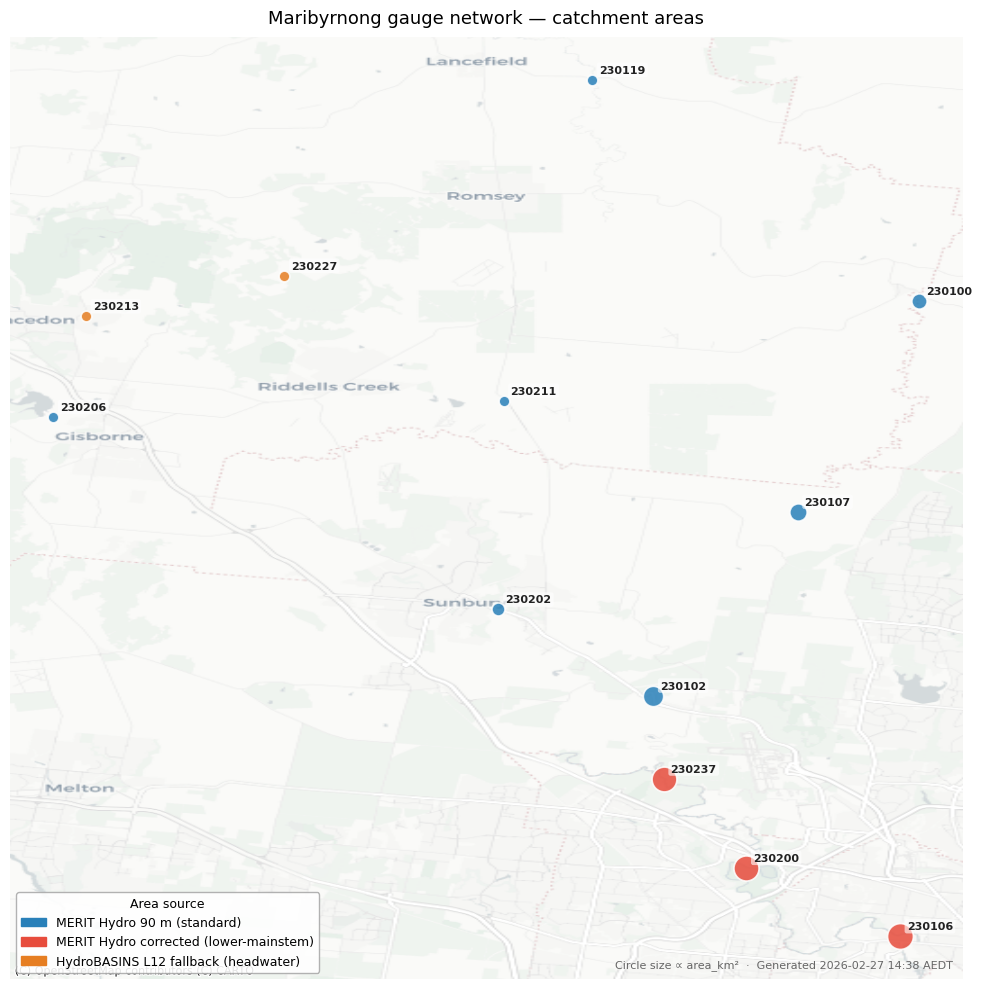

In [152]:
try:
    import contextily as ctx
except ModuleNotFoundError:
    import subprocess, sys
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'contextily', '-q'])
    import contextily as ctx

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pyproj
from datetime import datetime
from zoneinfo import ZoneInfo

# ── Gauge categories ───────────────────────────────────────────────────────────
MAINSTEM_CORRECTED = {'ausvic_230237', 'ausvic_230200', 'ausvic_230106'}
HEADWATER_FALLBACK = {'ausvic_230213', 'ausvic_230227'}

def gauge_colour(gid):
    if gid in MAINSTEM_CORRECTED: return '#e74c3c'   # red
    if gid in HEADWATER_FALLBACK:  return '#e67e22'   # orange
    return '#2980b9'                                   # blue

# ── Plot ───────────────────────────────────────────────────────────────────────
transformer = pyproj.Transformer.from_crs('EPSG:4326', 'EPSG:3857', always_xy=True)

fig, ax = plt.subplots(figsize=(10, 10))

for g in GAUGES:
    x, y   = transformer.transform(g['lon'], g['lat'])
    colour = gauge_colour(g['gauge_id'])
    size   = max(60, g['area_km2'] * 0.25)   # circle area ∝ area_km²
    ax.scatter(x, y, s=size, c=colour, alpha=0.85,
               edgecolors='white', linewidths=1.2, zorder=5)
    sid = g['gauge_id'].replace('ausvic_', '')
    ax.annotate(sid, xy=(x, y), xytext=(5, 5), textcoords='offset points',
                fontsize=8, fontweight='bold', color='#222',
                bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.6, ec='none'),
                zorder=6)

ctx.add_basemap(ax, crs='EPSG:3857', source=ctx.providers.CartoDB.Positron, zoom=11)

patches = [
    mpatches.Patch(color='#2980b9', label='MERIT Hydro 90 m (standard)'),
    mpatches.Patch(color='#e74c3c', label='MERIT Hydro corrected (lower-mainstem)'),
    mpatches.Patch(color='#e67e22', label='HydroBASINS L12 fallback (headwater)'),
]
ax.legend(handles=patches, loc='lower left', fontsize=9,
          framealpha=0.9, edgecolor='#aaa', title='Area source', title_fontsize=9)
ax.set_title('Maribyrnong gauge network — catchment areas', fontsize=13, pad=10)
_mel = ZoneInfo('Australia/Melbourne')
ts = datetime.now(_mel).strftime('%Y-%m-%d %H:%M %Z')
ax.annotate(
    f'Circle size ∝ area_km²  ·  Generated {ts}',
    xy=(0.99, 0.01), xycoords='axes fraction',
    ha='right', va='bottom', fontsize=8, color='#666',
)
ax.set_axis_off()
plt.tight_layout()
plt.show()
